# Stoke's Drift and Leeway

Objects at or near to the ocean's surface can experience additional forces that influence their movement. These include Stoke's drift, which occurs in the presence of surface gravity waves; and direct wind forcing, which can drive the movement of buoyant objects that partly sit above the ocean surface. Experimentally, when working at sea, it is difficult to isolate the impact of Stoke's drift from direct wind forcing. For this reason, the two are often modelled together as Leeway. The effect of Leeway is heavily dependent on the type of object under consideration, and this should be reflected in empirically derived parameter values. Search and rescue models often include a suite of parameters for different types of object (e.g. ships that that escaped their moorings, people in the water). In PyLag, the contribution of different factors (e.g., ocean currents, Stoke's Drift, direct wind forcing) to a particle's velocity are pooled and combined using an object of type VelocityAggregator. The code is designed to allow flexibility in the way the different components are brought together and accounted for. By default, the particle's velocity vector is modelled as a simple linear sum of the various components.

In real world applications, ocean circulation models are forced using surface wind data. However, the same data are not always included with the outputs of the ocean circulation model. Thus, if the impact of windage on particles is to be modelled along with the impact of ocean currents, the wind field may need to be read in separately. Furthermore, an ocean model may or may not have been run with a wave model; and even if the ocean circulation model was run with a wave model, the Stoke's drift velocity components may have been saved separately. To make it possible to read in wind and wave data that is stored in separate files, PyLag includes a suite of different data readers that can be used separately, or combined together, to read different types of data.

In this example, we demonstrate how PyLag can be used with data for surface ocean currents, surface winds and Stoke's drift that are stored in separate files. In total, three simulations are run: i) one that uses the surface velocity field only, ii) one that uses the surface velocity field with data for Stoke's drift, and iii) one that uses the surface velocity field with the surface wind field and a parameterisation of Leeway.

For input data, we use:

* **Surface ocean currents** - The example uses CMEMS Product NWS_ANALYSIS_FORECAST_004_013. The product was created using the UK Met Office Forecast Ocean and Assimilation Model (FOAM). The model uses NEMO v3.6, WAVEWATCH-III v4.18 and NEMOVAR v6. The model is run on the Atlantic Margin Model 1.5 km domain, and includes tides. This is a two-way coupled model (ocean-waves) setup. The data is hourly. 


* **Stoke's Drift** - The example uses CMEMS Product NWS_ANALYSIS_FORECAST_004_014. The product includes the outputs from WAVEWATCH-III, which was run with NEMO to generate product NWS_ANALYSIS_FORECAST_004_013. The data is three hourly.


* **Surface winds** - The example uses ERA5 10 m wind components from the Climate Data Store (DOI: 10.24381/cds.adbb2d47). The data is hourly.

<div class="alert alert-info">

**Note:**

If the ocean circulation model was not coupled to a wave model when it was run, one should be wary of dynamical inconsistencies between the two.
    
</div>

As with the other examples, the output files needed for the example can be [downloaded here](https://drive.google.com/open?id=15UX7Y9JnuLpnPAz700mzmzd917nTClxR). If you would like to run the code in this notebook interactively, download the data into a directory of your chooising. By default, the notebook will look for these files in the directory `${HOME}/data/pylag_doc`. To change this, simply update the *data_dir* path below.

In [1]:
import os
import pathlib


# Root directory for PyLag example input files
data_dir=f"{os.environ['HOME']}/data/pylag_doc"

# Path to the ocean data
ocean_data_dir = f"{data_dir}"

# Path to the wave data
wave_data_dir = f"{data_dir}"

# Path to the wind data
wind_data_dir = f"{data_dir}"

# Keep a copy of the cwd
cwd = os.getcwd()

# Create run directory
simulation_dir = f'{cwd}/simulations/stokes_drift_and_leeway'
pathlib.Path(simulation_dir).mkdir(parents=True, exist_ok=True)

## Creating the grid metrics files

In this example, we must create three grid metrics files for the three data sets (i.e. for the ocean, wave and wind data). The data do not need to be on the same grid. In this example, all three data sets are on a standard Arakawa A-grid: the ocean and wave datasets use the same AMM15 grid, while the wind data are defined on a global grid with a resolution of 0.25 degrees. The respective grid metrics files are created separately below.

In [2]:
from pylag.grid_metrics import create_arakawa_a_grid_metrics_file

# Create the ocean grid metrics file
# ----------------------------------

# An example NEMO AMM15 ocean data file in which the data are defined on a regular Arakawa A-grid.
ocean_data_file_name = f'{ocean_data_dir}/NWS_ANALYSIS_FORECAST_004_013_uv_2021_07_01.nc'

# Create input sub-directory
input_dir = f'{simulation_dir}/input'.format(simulation_dir)
pathlib.Path(input_dir).mkdir(parents=True, exist_ok=True)

# The name of the output file
ocean_grid_metrics_file_name = f'{input_dir}/ocean_grid_metrics.nc'

# Generate the file if it has not been created already
if not os.path.exists(ocean_grid_metrics_file_name):
    print('\n\nCreating ocean grid metrics file ...\n\n')
    create_arakawa_a_grid_metrics_file(ocean_data_file_name,
                                       dim_names={'longitude': 'lon', 'latitude': 'lat'},
                                       lon_var_name='lon',
                                       lat_var_name='lat',
                                       reference_var_name='uo',
                                       surface_only=True,
                                       grid_metrics_file_name=ocean_grid_metrics_file_name)



Creating ocean grid metrics file ...


Reading the grid:
Reading variable `lon` ... done
Reading variable `lat` ... done
Reading variable `uo` ... done
Sorting axes for variable `uo`... done

Creating the triangulation ... done

Generating the land sea mask at element nodes:

Sorting the adjacency array ... done

Calculating lons and lats at element centres ... done

Calculating element areas ... done

Generating land sea mask at element centres ... done

Mask elements with two land boundaries ... done

Flagging open boundaries ... done

Creating grid metrics file /users/modellers/jcl/code/git/PyLag/PyLag/doc/source/examples/simulations/stokes_drift_and_leeway/input/ocean_grid_metrics.nc ... done


In [3]:
# Create the wave grid metrics file
# ----------------------------------

# An example WWIII AMM7 wave data file in which the data are defined on a regular Arakawa A-grid.
wave_data_file_name = f'{wave_data_dir}/NWSHELF_REANALYSIS_WAV_004_015-TDS_uv_stokes_2021_07_01.nc'

# The name of the output file
wave_grid_metrics_file_name = f'{input_dir}/wave_grid_metrics.nc'

# Generate the file if it has not been created already
if not os.path.exists(wave_grid_metrics_file_name):
    print('\n\nCreating wave grid metrics file ...\n')
    create_arakawa_a_grid_metrics_file(wave_data_file_name,
                                       lon_var_name='longitude',
                                       lat_var_name='latitude',
                                       surface_only=True,
                                       save_mask=False,
                                       grid_metrics_file_name=wave_grid_metrics_file_name)



Creating wave grid metrics file ...

Reading the grid:
Reading variable `longitude` ... done
Reading variable `latitude` ... done

Creating the triangulation ... done

Sorting the adjacency array ... done

Calculating lons and lats at element centres ... done

Calculating element areas ... done

Flagging open boundaries ... done

Creating grid metrics file /users/modellers/jcl/code/git/PyLag/PyLag/doc/source/examples/simulations/stokes_drift_and_leeway/input/wave_grid_metrics.nc ... done


In [4]:
# Create the wind grid metrics file
# ---------------------------------

# An example ERA5 wind data file in which the data are defined on a regular Arakawa A-grid.
wind_data_file_name = f'{wind_data_dir}/era5_winds_2021_07.nc'

# The name of the output file
wind_grid_metrics_file_name = f'{input_dir}/wind_grid_metrics.nc'

# Generate the file if it has not been created already
if not os.path.exists(wind_grid_metrics_file_name):
    print('\n\nCreating wind grid metrics file ...\n')
    create_arakawa_a_grid_metrics_file(wind_data_file_name,
                                       lon_var_name='longitude',
                                       lat_var_name='latitude',
                                       is_global=True,
                                       surface_only=True,
                                       save_mask=False,
                                       grid_metrics_file_name=wind_grid_metrics_file_name)



Creating wind grid metrics file ...

Reading the grid:
Reading variable `longitude` ... done
Reading variable `latitude` ... done
Trimming first latitude which sits over a pole (90.0 deg.)
Trimming last latitude which sits over a pole (-90.0 deg.)

Creating the triangulation ... done

Identifying neighbour simplices:

Searching for adjoining neighbours with k = 4 ... found 55.566528678969014 %

Searching for adjoining neighbours with k = 16 ... found 89.85466862669723 %

Searching for adjoining neighbours with k = 64 ... found 97.67742172272779 %

Searching for adjoining neighbours with k = 256 ... found 99.86019328580066 %

Searching for adjoining neighbours with k = 1024 ... found 100.0 %

Sorting the adjacency array ... done

Calculating lons and lats at element centres ... done

Calculating element areas ... done

Creating grid metrics file /users/modellers/jcl/code/git/PyLag/PyLag/doc/source/examples/simulations/stokes_drift_and_leeway/input/wind_grid_metrics.nc ... done


Tests were included which mean the files are only created if they don't exists already; the creation of the grid metrics file is relatively expensive, but only needs to be done once. It should also be noted we only generated a land mask for the ocean data, and it is this which is used to determine interactions with the land boundary. For the other two datasets, masked points are replaced by zeros during run time. See the online docs for a full list of arguments accepted by [create_arakawa_a_grid_metrics_file](https://pylag.readthedocs.io/en/latest/api/pylag.grid_metrics.html#pylag.grid_metrics.create_arakawa_a_grid_metrics_file).

## Setting particle initial positions

We first create a PyLag initial positions file. For the purpose of the tutorial, we do this by placing particles in a small cloud of radius 500 m, centered on [Station L4](https://www.westernchannelobservatory.org.uk/) in the Western English Channel (-4.17 E, 50.25 N). The data on particle initial positions will be resued in each of the three model simulations, so we only create one file.

In [5]:
from pylag.processing.coordinate import get_epsg_code, utm_from_lonlat, lonlat_from_utm
from pylag.processing.release_zone import create_release_zone
from pylag.processing.input import create_initial_positions_file_single_group


# The group ID of this particle set
group_id = 1

# Lat and lon coordiantes for the centre of the release zone
lon = -4.17
lat = 50.25

# Convert to UTM coordinates
epsg_code = get_epsg_code(lon, lat)
easting, northing, _ = utm_from_lonlat(lon, lat, epsg_code=epsg_code)

# utm_from_lonlat returns lists - take the first element only
easting = easting[0]
northing = northing[0]

# Release zone radius (m)
radius = 500.0

# Number of particles to be released.
n_particles = 10

# Release depths
depth_below_surface = 0.0

# Create the release zone
surface_release_zone = create_release_zone(group_id = group_id,
                                           radius = radius,
                                           centre = [easting, northing],
                                           n_particles = n_particles,
                                           depth = depth_below_surface,
                                           random = True)

# Convert to lat/lon coordinates
lons, lats = lonlat_from_utm(surface_release_zone.get_eastings(),
                             surface_release_zone.get_northings(),
                             epsg_code=epsg_code)

# Get depths
depths = surface_release_zone.get_depths()

# Write data to file
file_name = f'{input_dir}/initial_positions.dat'.format(input_dir)
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           lons,
                                           lats,
                                           depths)

## Set the run time

We define here the run time, based on the bottle position at different times.

In [6]:
# Set a transit time of 12 days
pylag_start_datetime = "2021-07-01 01:00:00"
pylag_end_datetime = "2021-07-02 18:00:00"

## Creating the run configuration files

The example uses three run configuration files, one for each run. These determine which PyLag components are used to compute particle trajectories. The run configuration files are based off templates, which are provided with the code. First, we generate the *ocean only* run configuration file from the template and save it in the *simulation* directory.

In [7]:
import configparser

config_file_name = './configs/stokes_drift_and_leeway_template.cfg'

cf = configparser.ConfigParser()
cf.read(config_file_name)

# Set paths for ocean data
cf.set('OCEAN_CIRCULATION_MODEL', 'data_dir', ocean_data_dir)
cf.set('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file', ocean_grid_metrics_file_name)

# Assert we are not running with wave data or trying to include the impact of Stoke's drift.
cf.set('WAVE_DATA', 'name', 'none')
cf.set('STOKES_DRIFT', 'stokes_drift_calculator', 'none')

# Assert we are not running with atmospheric data or trying to include windage or leeway.
cf.set('ATMOSPHERE_DATA', 'name', 'none')
cf.set('WINDAGE', 'windage_calculator', 'none')

# Set start time
cf.set('SIMULATION', 'start_datetime', pylag_start_datetime)

# Set stop time
cf.set('SIMULATION', 'end_datetime', pylag_end_datetime)

# Directory where the simulation outputs will be saved
ocean_only_out_dir = f"{simulation_dir}/ocean_only_output"
cf.set('GENERAL', 'out_dir', ocean_only_out_dir)

# Save a copy in the simulation directory
ocean_only_config_file_name = 'ocean_only_pylag.cfg'
with open(f"{simulation_dir}/{ocean_only_config_file_name}", 'w') as config:
    cf.write(config)

Settings for Stoke's drift are specified in two sections of the run configuration file. The first is called *WAVE_DATA*. In this section, configuration parameters allow the user to provide details about the driving wave data. For example, the type of grid the data are definted on, the names of dimension and coordinate variables etc. The second section is called *STOKES_DRIFT*. Here, the approach for calculating Stoke's Drift data is specified using the parameter *stokes_drift_calculator*.

In [8]:
config_file_name = './configs/stokes_drift_and_leeway_template.cfg'

cf = configparser.ConfigParser()
cf.read(config_file_name)

# Set paths for ocean data
cf.set('OCEAN_CIRCULATION_MODEL', 'data_dir', ocean_data_dir)
cf.set('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file', ocean_grid_metrics_file_name)

# Assert we are not running with atmospheric data or trying to include windage or leeway.
cf.set('ATMOSPHERE_DATA', 'name', 'none')
cf.set('WINDAGE', 'windage_calculator', 'none')

# Assert that we are using wave data and calculating Stoke's drift at the surface.
cf.set('WAVE_DATA', 'name', 'standard')
cf.set('WAVE_DATA', 'data_dir', wave_data_dir)
cf.set('WAVE_DATA', 'grid_metrics_file', wave_grid_metrics_file_name)
cf.set('STOKES_DRIFT', 'stokes_drift_calculator', 'surface')

# Set start time
cf.set('SIMULATION', 'start_datetime', pylag_start_datetime)

# Set stop time
cf.set('SIMULATION', 'end_datetime', pylag_end_datetime)

# Directory where the simulation outputs will be saved
stokes_drift_out_dir = f"{simulation_dir}/stokes_drift_output"
cf.set('GENERAL', 'out_dir', stokes_drift_out_dir)

# Save a copy in the simulation directory
stokes_drift_config_file_name = 'stokes_drift_pylag.cfg'
with open(f"{simulation_dir}/{stokes_drift_config_file_name}", 'w') as config:
    cf.write(config)

Finally, we create a run configuration file for modelling the impact of direct wind forcing on an object's movement. Here, we must specify settings in three different sections. The first is the section *ATMOSPHERE_DATA*, where details of the atmospheric data (specifically the wind) are given. This includes a parameter where the path to the data is specified, and parameters where dimension and variable names can be listed (among others). The second is the section "WINDAGE". This is where the type of *windage_calculator* is specified. The choice determins how the wind data will be used.  Here, we use a windage calculator that specifies a fixed wind factor, which is applied to the wind speed. In very simple terms, this can be viewed as a model of Leeway, where the impact of waves and direct wind forcing on an object's movement are subsumed into a single parameter, under the assumption that the object moves in a downwind direction (i.e. with zero deflection). In this example, we used a wind factor of 1 %.

In [9]:
config_file_name = './configs/stokes_drift_and_leeway_template.cfg'

cf = configparser.ConfigParser()
cf.read(config_file_name)

# Set paths for ocean data
cf.set('OCEAN_CIRCULATION_MODEL', 'data_dir', ocean_data_dir)
cf.set('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file', ocean_grid_metrics_file_name)

# Set paths for atmospheric data
cf.set('ATMOSPHERE_DATA', 'name', 'standard')
cf.set('ATMOSPHERE_DATA', 'data_dir', wind_data_dir)
cf.set('ATMOSPHERE_DATA', 'grid_metrics_file', wind_grid_metrics_file_name)

# Specify the type of windage calculator we will use
cf.set('WINDAGE', 'windage_calculator', 'fixed_drag')
cf.set('FIXED_DRAG_WINDAGE_CALCULATOR', 'drag_coefficient', '0.01')

# Assert we are not running with wave data or trying to include the impact of Stoke's drift.
cf.set('WAVE_DATA', 'name', 'none')
cf.set('STOKES_DRIFT', 'stokes_drift_calculator', 'none')

# Set start time
cf.set('SIMULATION', 'start_datetime', pylag_start_datetime)

# Set stop time
cf.set('SIMULATION', 'end_datetime', pylag_end_datetime)

# Directory where the simulation outputs will be saved
leeway_out_dir = f"{simulation_dir}/leeway_output"
cf.set('GENERAL', 'out_dir', leeway_out_dir)

# Save a copy in the simulation directory
leeway_config_file_name = 'leeway_pylag.cfg'
with open(f"{simulation_dir}/{leeway_config_file_name}", 'w') as config:
    cf.write(config)

## Running the model

With the run configuration files saved, we can now run the three model simulations. We run them one after another.

In [10]:
# Change to the run directory
os.chdir(f'{simulation_dir}')

# Run the ocean only model
!{"python -m pylag.main -c ocean_only_pylag.cfg"}

# Run the ocean + windage model
!{"python -m pylag.main -c stokes_drift_pylag.cfg"}

# Run the ocean + windage model
!{"python -m pylag.main -c leeway_pylag.cfg"}

# Return to the cwd
os.chdir(cwd)


Starting ensemble member 1 ...
Progress:
100% |###########################################|

Starting ensemble member 1 ...
Progress:
100% |###########################################|

Starting ensemble member 1 ...
Progress:
100% |###########################################|


## Visualising the result

Having run the models, the final step is to visulise the result. Here, we produce a simple plot of particle pathlines over the course of the simulation.

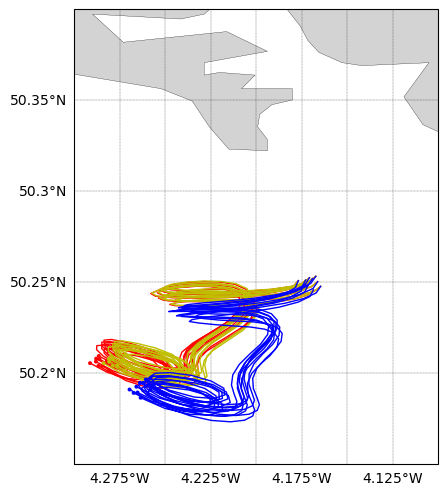

In [11]:
import numpy as np
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pylag.processing.ncview import Viewer
from pylag.processing.plot import create_figure, ArakawaAPlotter


%matplotlib inline


# Plot options
font_size = 10

# Create figure
fig, ax = create_figure(figure_size=(15., 15.), projection=ccrs.PlateCarree(),
                        font_size=font_size, bg_color='white')

# Configure plotter
plotter = ArakawaAPlotter(ocean_grid_metrics_file_name,
                          font_size=font_size)

extents = np.array([-4.3, -4.1, 50.15, 50.4])

# Add tracks from the ocean only run
# ----------------------------------
# PyLag file name
file_name = f'{ocean_only_out_dir}/pylag_1.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='r', edgecolors='none',
                configure=True,
                draw_coastlines=True,
                tick_inc=True,
                extents=extents)

# Add high resolution land
ax.add_feature(cfeature.LAND, facecolor='lightgrey')

# Plot paths
_ = plotter.plot_lines(ax,
                       viewer('longitude')[:, :].squeeze(),
                       viewer('latitude')[:, :].squeeze(),
                       linewidth=1., alpha=1, color='r')


# Add tracks from the ocean + stokes drift run
# --------------------------------------------
# PyLag file name
file_name = f'{stokes_drift_out_dir}/pylag_1.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='y', edgecolors='none')

# Plot paths
_ = plotter.plot_lines(ax,
                       viewer('longitude')[:, :].squeeze(),
                       viewer('latitude')[:, :].squeeze(),
                       linewidth=1., alpha=1, color='y')


# Add tracks from the ocean + leeway run
# --------------------------------------
# PyLag file name
file_name = f'{leeway_out_dir}/pylag_1.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='b', edgecolors='none')

# Plot paths
_ = plotter.plot_lines(ax,
                       viewer('longitude')[:, :].squeeze(),
                       viewer('latitude')[:, :].squeeze(),
                       linewidth=1., alpha=1, color='b')

In the plot, the red coloured lines show the tracks from the Ocean only run; the mustard coloured lines shows tracks from the Ocean + Stoke's Drift run; and the blue coloured lines show the tracks from the run with Ocean + Leeway run.